In [78]:
## Notebook env: mirtud_env (mirtud_env kernel)
import numpy as np
import pandas as pd
import scanpy as sc
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [79]:
%%R
library(Seurat)
library(ggplot2)
library(tidyr)
library(cowplot)
library(aplot)
library(patchwork)
library(ggtree)
library(dplyr)

In [80]:
%%R
## get R version of PCA coordinates that have weights
adata.R = readRDS('/home/ssobti/projects/mir_tud/010523_filtered_data/miR_normalized_integrated_seurat.rds')
meta = adata.R@meta.data

In [81]:
%%R
scaled_scores <- scale(Embeddings(adata.R, reduction = "pca"))
var_rot <- varimax(Loadings(adata.R, reduction = "pca"))$rotmat
rotated_varimax_scores <- scaled_scores %*% var_rot

In [82]:
%%R
vari_weights = varimax(Loadings(adata.R, reduction = "pca"))
vari_weights = vari_weights$loadings
vari_weights[1:5,1:5]

              PC_1        PC_2         PC_3          PC_4          PC_5
IFIT2 -0.010907453 0.002815424  0.011872409 -0.0044128251 -0.0038884464
IFIT3 -0.003904446 0.007061878  0.007961426  0.0000171365 -0.0037172346
IFIT1  0.005096107 0.001910319  0.000452338 -0.0060331203  0.0008821542
OASL  -0.003059867 0.004559411  0.019185094  0.0017159237 -0.0014871808
CDH1  -0.001087855 0.002699645 -0.006597429  0.0058225829  0.0020660979


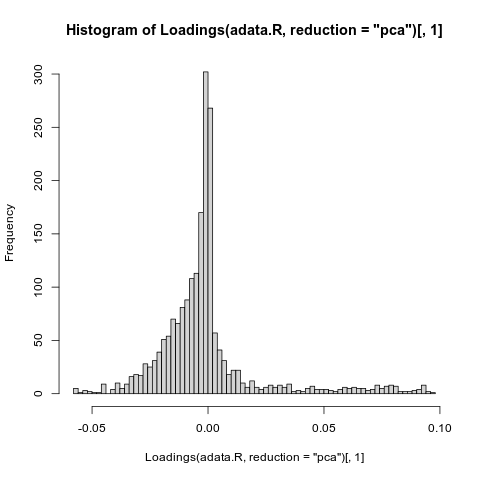

In [83]:
%%R
## genes with high weights in PC1 from original PCA
hist(Loadings(adata.R, reduction = "pca")[,1], breaks = 100)

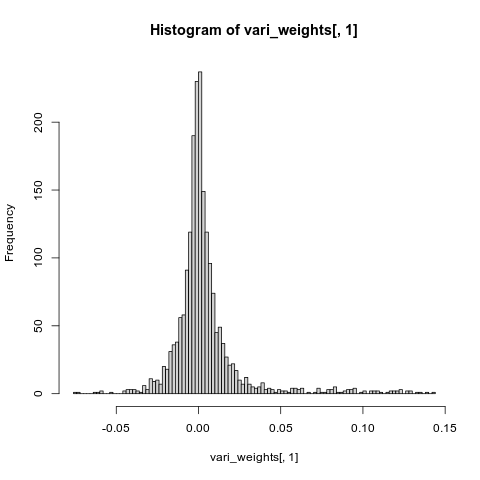

In [84]:
%%R
## genes with high weights in PC1 from varimax rotation
hist(vari_weights[,1], breaks = 100)

In [7]:
%%R
## build linear model between rotated scores and cell guide identity, pick best fit model for each PC from log likelihood ratio test p-value

uniq = unique(meta$guide)
fitted_models = list()
fit_pvals = list()
pb = txtProgressBar(min = 0, max = ncol(rotated_varimax_scores), style = 3)
for (j in 1:ncol(rotated_varimax_scores)){
    fitted_models[[j]] <- lapply(as.list(uniq), function(x) glm(identity ~ scores, data = data.frame(scores = rotated_varimax_scores[,j], identity = factor(meta$guide == x)), family = 'binomial'))
    fit_pvals[[j]] = lapply(fitted_models[[j]], function(x) with(x, pchisq(null.deviance - deviance, df.null - df.residual, lower.tail = FALSE)))
    setTxtProgressBar(pb, j)
}
close(pb)

  |======================================================================| 100%


In addition: Warning messages:
1: glm.fit: fitted probabilities numerically 0 or 1 occurred 
2: glm.fit: fitted probabilities numerically 0 or 1 occurred 


In [8]:
%%R
fit_pvals_adj = lapply(fit_pvals, function(x) p.adjust(as.numeric(unlist(x)), method = 'BH'))
fit_pvals_adj = lapply(fit_pvals_adj, function(x) -log10(x))

In [9]:
%%R
save(fitted_models, fit_pvals, fit_pvals_adj, file = '/home/ssobti/projects/mir_tud/output_data/genexp_pathway/PC_scores/miR_varimax_rot_logit_fit_data.RData')

In [3]:
%%R
load('/home/ssobti/projects/mir_tud/output_data/genexp_pathway/PC_scores/miR_varimax_rot_logit_fit_data.RData')

In [ ]:
%%R
save(fit_pvals, fit_pvals_adj, file = '/home/ssobti/projects/mir_tud/output_data/genexp_pathway/PC_scores/miR_varimax_rot_logit_fit_data_pvals_only.RData')

In [85]:
%%R
#load('/home/ssobti/projects/mir_tud/output_data/genexp_pathway/PC_scores/miR_varimax_rot_logit_fit_data_pvals_only.RData')

In [86]:
%%R
uniq = unique(meta$guide)
df = data.frame(matrix(unlist(fit_pvals_adj), nrow = length(fit_pvals_adj), byrow = T))
colnames(df) = uniq
df$y = paste0('RC', 1:ncol(rotated_varimax_scores))
df_long <- pivot_longer(df, cols = -c(y), names_to = 'x', values_to = 'value')
d <- as.data.frame(df_long)
head(d)

    y               x       value
1 RC1 hsa-miR-203a-3p 0.007761278
2 RC1   hsa-miR-93-3p 0.007761278
3 RC1 hsa-miR-130b-3p 0.007761278
4 RC1       TuD_NC_18 0.007761278
5 RC1 hsa-miR-147b-5p 0.007761278
6 RC1  hsa-miR-501-5p 0.007761278


In [87]:
%%R
dim(df)

[1]  50 398


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 14292 rows containing missing values (`geom_tile()`). 



the plot was flipped and the x limits will be applied to y-axis
In addition: Warning message:
Removed 14292 rows containing missing values (`geom_tile()`). 


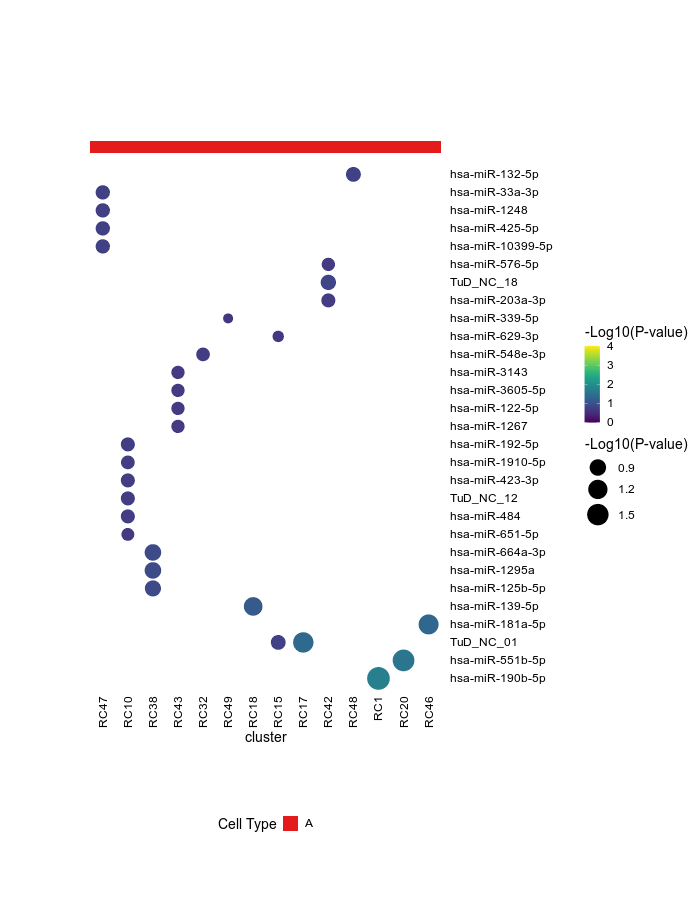

In [88]:
%%R -w 700 -h 900
gene_cluster = d
colnames(gene_cluster) = c('cluster', 'Gene', 'count')

# make data square to calculate euclidean distance
mat <- gene_cluster %>% # drop unused columns to faciliate widening
  pivot_wider(names_from = cluster, values_from = count) %>%
  data.frame() # make df as tibbles -> matrix annoying
row.names(mat) <- mat$Gene  # put gene in `row`
mat <- mat[,-1] #drop gene column as now in rows
clust <- hclust(dist(mat %>% as.matrix())) 
v_clust <- hclust(dist(mat %>% as.matrix() %>% t())) # hclust with distance matrix
############ NOTICE THE t() above)

ddgram_col <- as.dendrogram(v_clust)
ggtree_plot_col <- ggtree(ddgram_col) + layout_dendrogram()

dotplot <- gene_cluster %>% 
  mutate(Gene = factor(Gene, levels = clust$labels[clust$order]),
         cluster = factor(cluster, levels = v_clust$labels[v_clust$order])) %>%
         filter(count > (-log10(0.25))) %>%
  ggplot(aes(x=cluster, y = Gene, color = count, size = count)) + 
  geom_point() + 
  cowplot::theme_cowplot() + 
  theme(axis.line  = element_blank()) +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
  ylab('') +
  theme(axis.ticks = element_blank()) +
  scale_color_gradientn(colours = viridis::viridis(20), limits = c(0,4), oob = scales::squish, name = '-Log10(P-value)') +
  scale_size_continuous(name = '-Log10(P-value)', range = c(4,10)) +
  scale_y_discrete(position = "right")
#################################################
ggtree_plot_col <- ggtree_plot_col + xlim2(dotplot)


ddgram <- as.dendrogram(clust) # create dendrogram
ggtree_plot <- ggtree::ggtree(ddgram)
ggtree_plot <- ggtree_plot + ylim2(dotplot)

labels <- ggplot(gene_cluster %>% 
                   mutate(`Cell Type` = rep('A', nrow(gene_cluster)),
                           cluster = factor(cluster, levels = v_clust$labels[v_clust$order])), 
                 aes(x = cluster, y = 1, fill = `Cell Type`)) + 
  geom_tile() + 
  scale_fill_brewer(palette = 'Set1') + 
  theme_nothing() +
  xlim2(dotplot)

legend <- plot_grid(get_legend(labels + theme(legend.position="bottom")))

plot_spacer() + plot_spacer() + plot_spacer() +
  plot_spacer() + plot_spacer() + labels +
  plot_spacer() + plot_spacer() + plot_spacer() +
  plot_spacer() + plot_spacer() + dotplot + 
  plot_spacer() + plot_spacer() + legend + 
  plot_layout(ncol = 3, widths = c(0.7, -0.1, 4), heights = c(0.9, 0.1, -0.1, 4, 1))

In [89]:
%%R
ggsave('/home/ssobti/projects/mir_tud/output_data/genexp_pathway/PC_scores/miR_varimax_rot_logit_fit_plot.pdf', width = 14, height = 14)

In addition: Warning message:
Removed 14292 rows containing missing values (`geom_tile()`). 


In [90]:
%%R
## save significant RCs
significant_RCs = gene_cluster %>% 
  mutate(Gene = factor(Gene, levels = clust$labels[clust$order]),
         cluster = factor(cluster, levels = v_clust$labels[v_clust$order])) %>%
         filter(count > (-log10(0.25))) %>% select(cluster) %>% unique()

significant_RCs = as.character(significant_RCs$cluster)

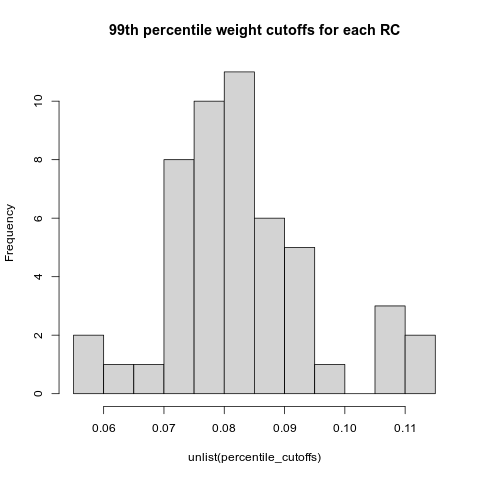

In [91]:
%%R
## graph the miRs in the clusters and pick out those with positive correlations (ie PC scores associated with that particular miR)
## pick out genes associated with significant weights (above 99th percentile for each PC -- basically top 20 genes for each PC)


percentile_cutoffs = apply(abs(vari_weights), 2, quantile, probs = 0.99)
genes_passing_cutoff = lapply(1:ncol(vari_weights), function(x) names(vari_weights[,x])[which(abs(vari_weights[,x]) > percentile_cutoffs[x])])
names(genes_passing_cutoff) = paste0('RC', 1:ncol(vari_weights))

hist(unlist(percentile_cutoffs), breaks = 10, main = '99th percentile weight cutoffs for each RC')

In [92]:
%%R

## replace with zero all below cutoffs
zero_below_thresh <- function(df, cutoffs){
    df = as.matrix(df)
    for (i in 1:ncol(df)){
    df[,i][abs(df[,i]) < cutoffs[i]] = 0
    colnames(df)[i] = paste0('RC', i)
    }
    return(df)
}

vari_weights_abv_thresh = zero_below_thresh(vari_weights, percentile_cutoffs)
vari_weights_abv_thresh2 = zero_below_thresh(vari_weights, rep(0.1, ncol(vari_weights)))

In [93]:
%%R
vari_weights_abv_thresh = data.frame(matrix(as.numeric(vari_weights_abv_thresh), attributes(vari_weights_abv_thresh)$dim, dimnames=attributes(vari_weights_abv_thresh)$dimnames))
vari_weights_abv_thresh$y = rownames(vari_weights_abv_thresh)
weights_df <- pivot_longer(vari_weights_abv_thresh, cols = -c(y), names_to = 'x', values_to = 'value')
weights_df <- as.data.frame(weights_df)
head(weights_df)

      y   x value
1 IFIT2 RC1     0
2 IFIT2 RC2     0
3 IFIT2 RC3     0
4 IFIT2 RC4     0
5 IFIT2 RC5     0
6 IFIT2 RC6     0


In [94]:
%%R
vari_weights_abv_thresh2 = data.frame(matrix(as.numeric(vari_weights_abv_thresh2), attributes(vari_weights_abv_thresh2)$dim, dimnames=attributes(vari_weights_abv_thresh2)$dimnames))
vari_weights_abv_thresh2$y = rownames(vari_weights_abv_thresh2)
weights_df2 <- pivot_longer(vari_weights_abv_thresh2, cols = -c(y), names_to = 'x', values_to = 'value')
weights_df2 <- as.data.frame(weights_df2)
head(weights_df2)

      y   x value
1 IFIT2 RC1     0
2 IFIT2 RC2     0
3 IFIT2 RC3     0
4 IFIT2 RC4     0
5 IFIT2 RC5     0
6 IFIT2 RC6     0


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 80000 rows containing missing values (`geom_tile()`). 



the plot was flipped and the x limits will be applied to y-axis
In addition: Warning message:
Removed 80000 rows containing missing values (`geom_tile()`). 


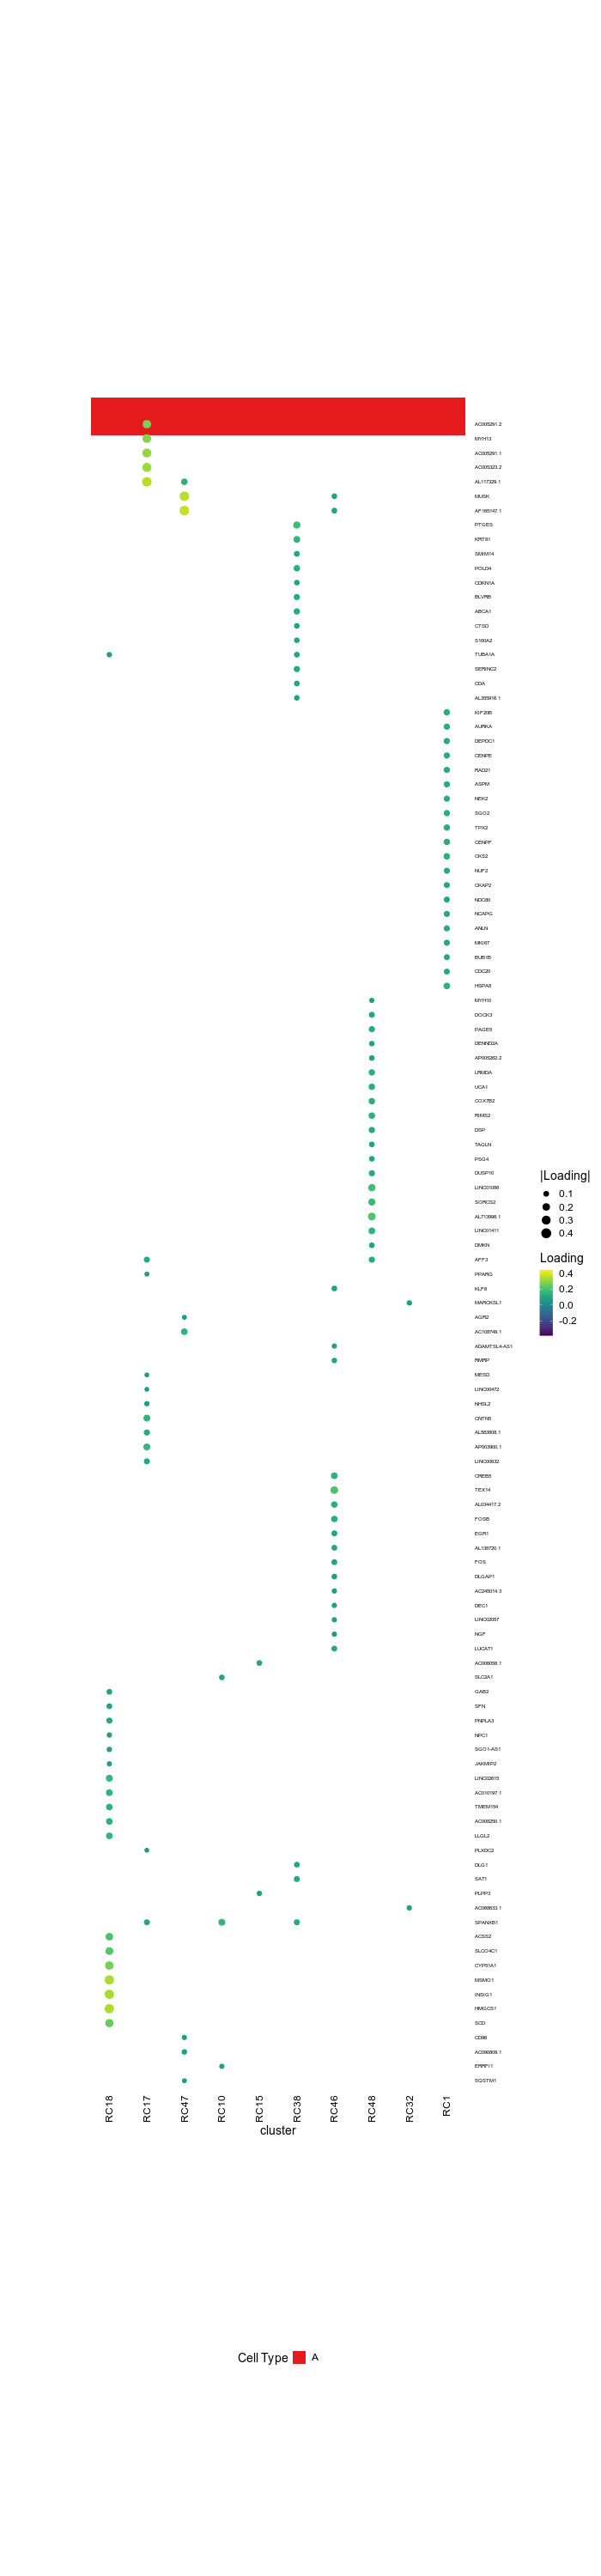

In [95]:
%%R -w 700 -h 3000
## genes with weights above 99th percentile for each RC shown

gene_cluster = weights_df
colnames(gene_cluster) = c('Gene', 'cluster', 'count')

# make data square to calculate euclidean distance
mat <- gene_cluster %>% # drop unused columns to faciliate widening
  pivot_wider(names_from = cluster, values_from = count) %>%
  data.frame() # make df as tibbles -> matrix annoying
row.names(mat) <- mat$Gene  # put gene in `row`
mat <- mat[,-1] #drop gene column as now in rows
clust <- hclust(dist(mat %>% as.matrix())) 
v_clust <- hclust(dist(mat %>% as.matrix() %>% t())) # hclust with distance matrix
############ NOTICE THE t() above)

ddgram_col <- as.dendrogram(v_clust)
ggtree_plot_col <- ggtree(ddgram_col) + layout_dendrogram()

dotplot <- gene_cluster %>% 
  mutate(Gene = factor(Gene, levels = clust$labels[clust$order]),
         cluster = factor(cluster, levels = v_clust$labels[v_clust$order])) %>%
         filter(cluster %in% significant_RCs) %>% filter(count > 0) %>%
  ggplot(aes(x=cluster, y = Gene, color = count, size = abs(count))) + 
  geom_point() + 
  cowplot::theme_cowplot() + 
  theme(axis.line  = element_blank()) +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1), axis.text.y = element_text(size = 6)) +
  ylab('') +
  theme(axis.ticks = element_blank()) +
  scale_color_gradientn(colours = viridis::viridis(20), limits = c(min(gene_cluster$count), max(gene_cluster$count)), oob = scales::squish, name = 'Loading') +
  scale_size_continuous(name = '|Loading|', range = c(0.2,5), limits = c(0.0001, max(gene_cluster$count))) +
  scale_y_discrete(position = "right")
#################################################
ggtree_plot_col <- ggtree_plot_col + xlim2(dotplot)


ddgram <- as.dendrogram(clust) # create dendrogram
ggtree_plot <- ggtree::ggtree(ddgram)
ggtree_plot <- ggtree_plot + ylim2(dotplot)

labels <- ggplot(gene_cluster %>% 
                   mutate(`Cell Type` = rep('A', nrow(gene_cluster)),
                           cluster = factor(cluster, levels = v_clust$labels[v_clust$order])), 
                 aes(x = cluster, y = 1, fill = `Cell Type`)) + 
  geom_tile() + 
  scale_fill_brewer(palette = 'Set1') + 
  theme_nothing() +
  xlim2(dotplot)

legend <- plot_grid(get_legend(labels + theme(legend.position="bottom")))

plot_spacer() + plot_spacer() + plot_spacer() +
  plot_spacer() + plot_spacer() + labels +
  plot_spacer() + plot_spacer() + plot_spacer() +
  plot_spacer() + plot_spacer() + dotplot + 
  plot_spacer() + plot_spacer() + legend + 
  plot_layout(ncol = 3, widths = c(0.7, -0.1, 4), heights = c(0.9, 0.1, -0.1, 4, 1))

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 84000 rows containing missing values (`geom_tile()`). 



the plot was flipped and the x limits will be applied to y-axis
In addition: Warning message:
Removed 84000 rows containing missing values (`geom_tile()`). 


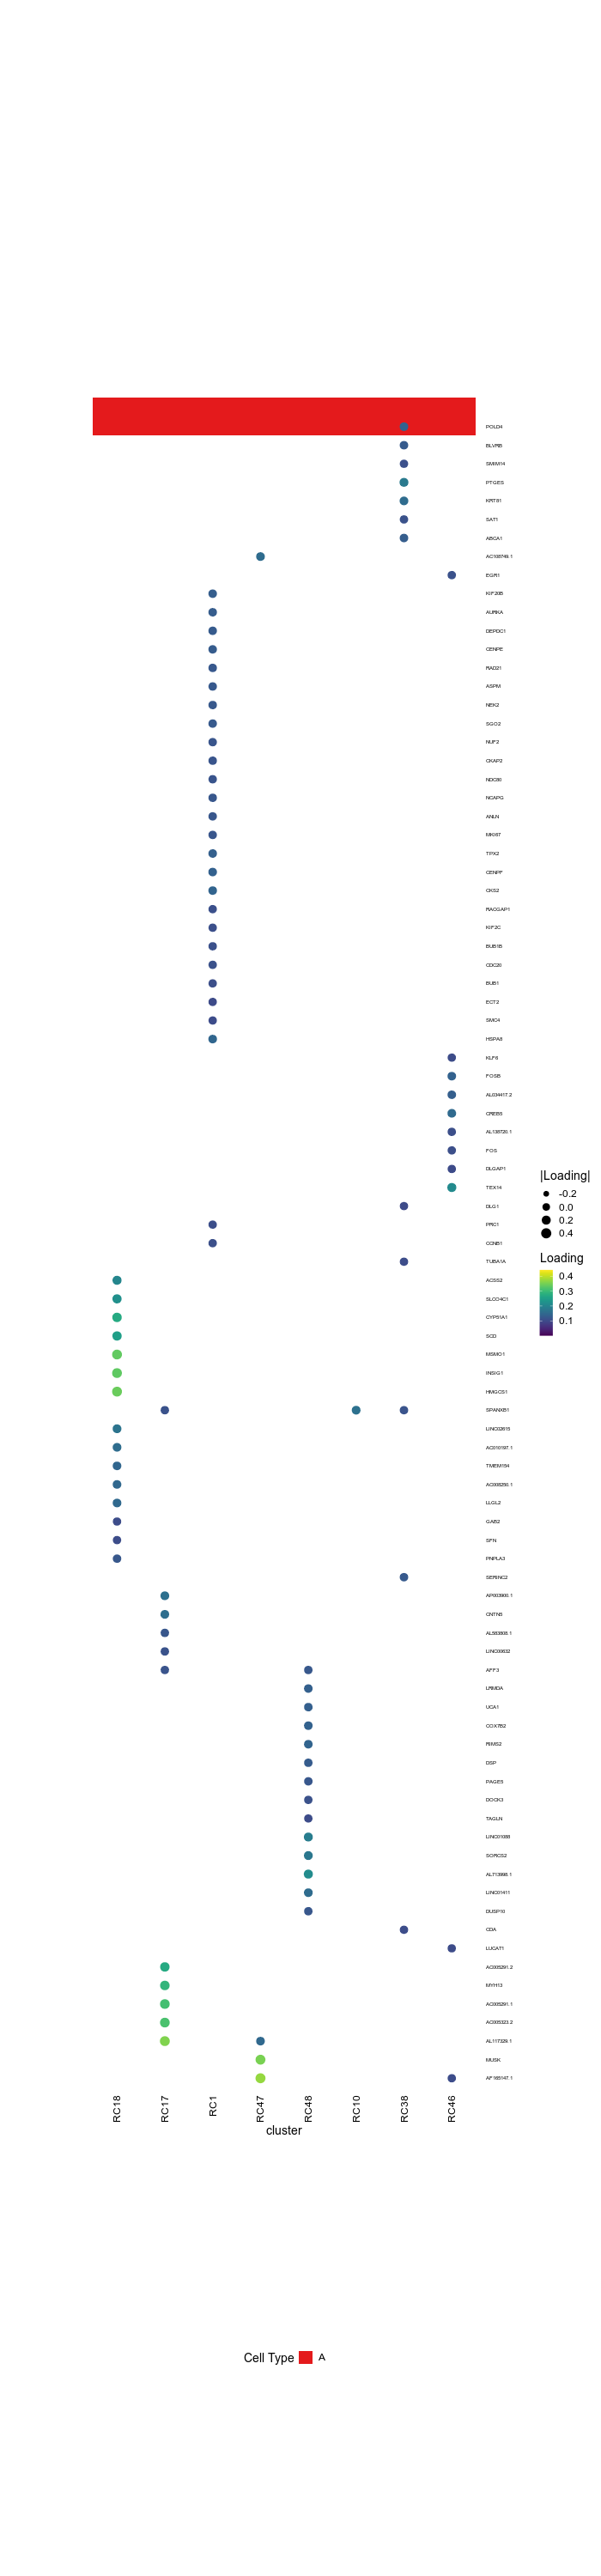

In [96]:
%%R -w 700 -h 3000
## genes with weights above 0.1 loading weight for each RC shown

gene_cluster = weights_df2
colnames(gene_cluster) = c('Gene', 'cluster', 'count')

# make data square to calculate euclidean distance
mat <- gene_cluster %>% # drop unused columns to faciliate widening
  pivot_wider(names_from = cluster, values_from = count) %>%
  data.frame() # make df as tibbles -> matrix annoying
row.names(mat) <- mat$Gene  # put gene in `row`
mat <- mat[,-1] #drop gene column as now in rows
clust <- hclust(dist(mat %>% as.matrix())) 
v_clust <- hclust(dist(mat %>% as.matrix() %>% t())) # hclust with distance matrix
############ NOTICE THE t() above)

ddgram_col <- as.dendrogram(v_clust)
ggtree_plot_col <- ggtree(ddgram_col) + layout_dendrogram()

dotplot <- gene_cluster %>% 
  mutate(Gene = factor(Gene, levels = clust$labels[clust$order]),
         cluster = factor(cluster, levels = v_clust$labels[v_clust$order])) %>%
         filter(cluster %in% significant_RCs) %>% filter(count > 0) %>%
  ggplot(aes(x=cluster, y = Gene, color = count, size = abs(count))) + 
  geom_point() + 
  cowplot::theme_cowplot() + 
  theme(axis.line  = element_blank()) +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1), axis.text.y = element_text(size = 6)) +
  ylab('') +
  theme(axis.ticks = element_blank()) +
  scale_color_gradientn(colours = viridis::viridis(20), limits = c(0.0001, max(gene_cluster$count)), oob = scales::squish, name = 'Loading') +
  scale_size_continuous(name = '|Loading|', range = c(0.2,5), limits = c(min(gene_cluster$count), max(gene_cluster$count))) +
  scale_y_discrete(position = "right")
#################################################
ggtree_plot_col <- ggtree_plot_col + xlim2(dotplot)


ddgram <- as.dendrogram(clust) # create dendrogram
ggtree_plot <- ggtree::ggtree(ddgram)
ggtree_plot <- ggtree_plot + ylim2(dotplot)

labels <- ggplot(gene_cluster %>% 
                   mutate(`Cell Type` = rep('A', nrow(gene_cluster)),
                           cluster = factor(cluster, levels = v_clust$labels[v_clust$order])), 
                 aes(x = cluster, y = 1, fill = `Cell Type`)) + 
  geom_tile() + 
  scale_fill_brewer(palette = 'Set1') + 
  theme_nothing() +
  xlim2(dotplot)

legend <- plot_grid(get_legend(labels + theme(legend.position="bottom")))

plot_spacer() + plot_spacer() + plot_spacer() +
  plot_spacer() + plot_spacer() + labels +
  plot_spacer() + plot_spacer() + plot_spacer() +
  plot_spacer() + plot_spacer() + dotplot + 
  plot_spacer() + plot_spacer() + legend + 
  plot_layout(ncol = 3, widths = c(0.7, -0.1, 4), heights = c(0.9, 0.1, -0.1, 4, 1))

In [97]:
%%R
## save genes of significant RCs
weights_df2_sig_genes = gene_cluster %>% 
  mutate(Gene = factor(Gene, levels = clust$labels[clust$order]),
         cluster = factor(cluster, levels = v_clust$labels[v_clust$order])) %>%
         filter(cluster %in% significant_RCs) %>% filter(abs(count) > 0) %>% arrange(cluster) %>% as.data.frame()

head(weights_df2_sig_genes)

        Gene cluster     count
1     HMGCS1    RC18 0.3406596
2 AC008250.1    RC18 0.1464315
3 AC010197.1    RC18 0.1566044
4        SCD    RC18 0.2488409
5        SFN    RC18 0.1038598
6    SLCO4C1    RC18 0.2219474


### Pathway analysis

In [98]:
%%R
## do pathway analysis on genes w/loading > 0.1 of each significant RC
library(enrichR)
setEnrichrSite("Enrichr")
dbs <- c("GO_Molecular_Function_2021", "GO_Cellular_Component_2021", "GO_Biological_Process_2021")
dbs <- c("GO_Biological_Process_2021")

Connection changed to https://maayanlab.cloud/Enrichr/
Connection is Live!


In [99]:
%%R
list_convert <- function(n, df) {
    clusters = unique(df$cluster)
    filtered_df = df %>% filter(cluster == clusters[n])
    return(as.character(filtered_df$Gene))
}

In [100]:
%%R
significant_genes_load_0.1 = lapply(1:length(unique(weights_df2_sig_genes$cluster)), list_convert, weights_df2_sig_genes)
names(significant_genes_load_0.1) = unique(weights_df2_sig_genes$cluster)

In [101]:
%%R
## there is a problem with the enrichr package, it requries a delay between queries to prevent repeat results for earlier inputs
## make sure none are identical -- make sure all false at bottom of output of this cell
enriched_list = list()

for (i in 1:length(significant_genes_load_0.1)) {
    enriched_list[[i]] = enrichr(as.character(significant_genes_load_0.1[[i]]), dbs)
    Sys.sleep(1)
}
enriched_list = lapply(enriched_list, '[[', 1)
sapply(enriched_list[-1], function(x) identical(x,enriched_list[[1]]))

Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  

In [102]:
%%R
## get top 3 pathways for each RC
Terms = lapply(enriched_list, function(x) x %>% select(Term, Combined.Score) %>% arrange(desc(Combined.Score)) %>% pull(Term) %>% head(3))
Scores = lapply(enriched_list, function(x) x %>% select(Term, Combined.Score) %>% arrange(desc(Combined.Score)) %>% pull(Combined.Score) %>% head(3) %>% as.numeric())
adjacency_table = data.frame(pathways = unlist(Terms), components = as.character(sapply(names(significant_genes_load_0.1), rep, each = 3)), scores = unlist(Scores))

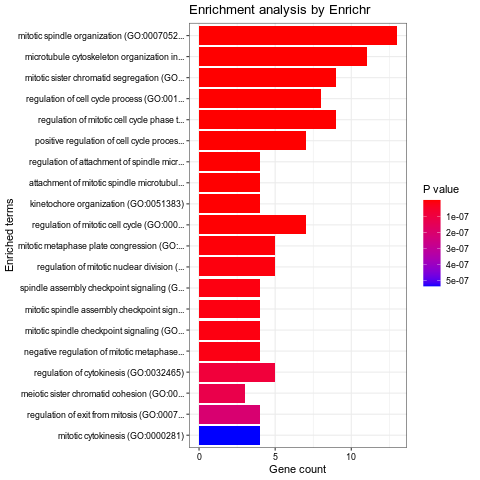

In [103]:
%%R
plotEnrich(enriched_list[[3]], showTerms = 20, numChar = 40, y = "Count", orderBy = "P.value")

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


the plot was flipped and the x limits will be applied to y-axis


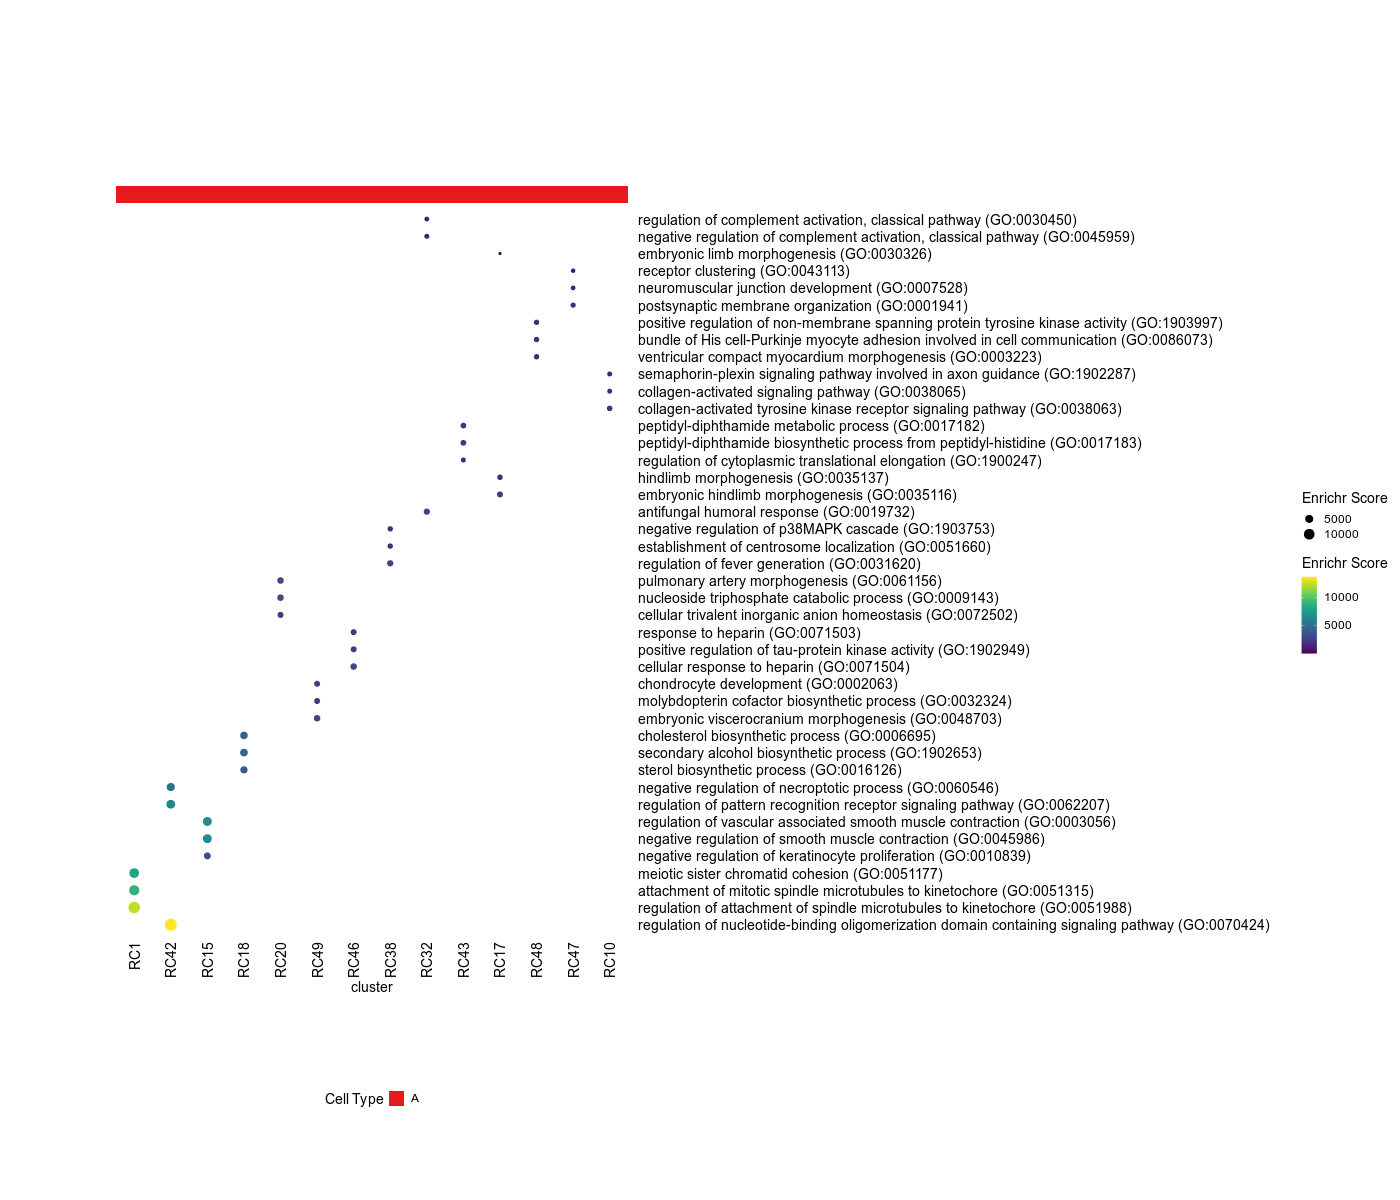

In [105]:
%%R -w 1400 -h 1200
gene_cluster = adjacency_table
colnames(gene_cluster) = c('Gene', 'cluster', 'count')

library(igraph)
mygraph <- graph_from_data_frame(gene_cluster)
mat <- as.matrix(get.adjacency(mygraph, sparse = FALSE, attr='count'))
mat <- select(as.data.frame(mat), starts_with("RC")) %>% filter(!startsWith(row.names(mat), "RC"))

clust <- hclust(dist(mat %>% as.matrix())) 
v_clust <- hclust(dist(mat %>% as.matrix() %>% t())) # hclust with distance matrix
############ NOTICE THE t() above)

ddgram_col <- as.dendrogram(v_clust)
ggtree_plot_col <- ggtree(ddgram_col) + layout_dendrogram()

dotplot <- gene_cluster %>% 
  mutate(Gene = factor(Gene, levels = clust$labels[clust$order]),
         cluster = factor(cluster, levels = v_clust$labels[v_clust$order])) %>%
         filter(cluster %in% significant_RCs) %>% filter(count > 0) %>%
  ggplot(aes(x=cluster, y = Gene, color = count, size = count)) + 
  geom_point() + 
  cowplot::theme_cowplot() + 
  theme(axis.line  = element_blank()) +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1, size = 14), axis.text.y = element_text(size = 14)) +
  ylab('') +
  theme(axis.ticks = element_blank()) +
  scale_color_gradientn(colours = viridis::viridis(20), limits = c(0.0001, max(gene_cluster$count)), oob = scales::squish, name = 'Enrichr Score') +
  scale_size_continuous(name = 'Enrichr Score', range = c(0.2,5), limits = c(0.0001, max(gene_cluster$count))) +
  scale_y_discrete(position = "right")
#################################################
ggtree_plot_col <- ggtree_plot_col + xlim2(dotplot)


ddgram <- as.dendrogram(clust) # create dendrogram
ggtree_plot <- ggtree::ggtree(ddgram)
ggtree_plot <- ggtree_plot + ylim2(dotplot)

labels <- ggplot(gene_cluster %>% 
                   mutate(`Cell Type` = rep('A', nrow(gene_cluster)),
                           cluster = factor(cluster, levels = v_clust$labels[v_clust$order])), 
                 aes(x = cluster, y = 1, fill = `Cell Type`)) + 
  geom_tile() + 
  scale_fill_brewer(palette = 'Set1') + 
  theme_nothing() +
  xlim2(dotplot)

legend <- plot_grid(get_legend(labels + theme(legend.position="bottom")))

plot_spacer() + plot_spacer() + plot_spacer() +
  plot_spacer() + plot_spacer() + labels +
  plot_spacer() + plot_spacer() + plot_spacer() +
  plot_spacer() + plot_spacer() + dotplot + 
  plot_spacer() + plot_spacer() + legend + 
  plot_layout(ncol = 3, widths = c(0.7, -0.1, 4), heights = c(0.9, 0.1, -0.1, 4, 1))
